In [110]:
import torch
import torch.nn as nn

import math
from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import uniform_filter1d
import sys
import time
import cv2

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [111]:
# load map data
filename = '/home/oscar_palfelt/MSc_thesis/LearnedSamplingDistributions/narrowDataFile.txt'

obsData = np.unique(np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[6, 7, 9, 10, 12, 13]), axis=0)
numEntries = obsData.shape[0]

In [112]:
# change conditions to occupancy grid
def isSampleFree(sample, obs):
    for o in list(range(0,obs.shape[0]//(2*dimW))): # python 2 -> 3: use list(), use //
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

gridSize = 11
dimW = 3
plotOn = False;

# process data into occupancy grid
conditions = np.copy(obsData)
conditionsOcc = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0;
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1;

start = time.time();
for j in range(0,numEntries,1):
    dw = 0.1
    gap1 = conditions[j,0:2]
    gap2 = conditions[j,2:4]
    gap3 = conditions[j,4:6]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 5000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    conditionsOcc[j,:] = occGrid
    
end = time.time();
print('Time: ', end-start)
    

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000
Iter: 30000
Time:  10.951420545578003


In [121]:
# define planning problem
class MyGoal(ob.Goal):
    def __init__(self, si):
        super(MyGoal, self).__init__(si)

    def isSatisfied(self, state):
        return np.linalg.norm(goal - np.array([state[0], state[1], state[2]])) < 0.1


def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


def isRV2StateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    u = int(np.floor(state[0] * occGrid.shape[1])) # right pointing image axis
    v = int(np.floor(occGrid.shape[0] * (1 - state[1]))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def isRV4Valid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    uTruck = int(np.floor(state[0] * gridSize)) # right pointing image axis
    vTruck = int(np.floor(gridSize * (1 - state[1]))) # down pointing image axis

    xTrailer1 = state[0] - b1 * np.cos(state[2]) - b2 * np.cos(state[3])
    yTrailer1 = state[1] - b1 * np.sin(state[2]) - b2 * np.sin(state[3])
    uTrailer1 = int(np.clip(np.floor(xTrailer1 * gridSize), 0, gridSize - 1))
    vTrailer1 = int(np.clip(np.floor(gridSize * (1 - yTrailer1)), 0, gridSize - 1))

    xTrailer2 = state[0] - b1 * np.cos(state[2]) - 0.3*b2 * np.cos(state[3])
    yTrailer2 = state[1] - b1 * np.sin(state[2]) - 0.3*b2 * np.sin(state[3])
    uTrailer2 = int(np.clip(np.floor(xTrailer2 * gridSize), 0, gridSize - 1))
    vTrailer2 = int(np.clip(np.floor(gridSize * (1 - yTrailer2)), 0, gridSize - 1))

    #return True
    if spaceInformation.satisfiesBounds(state):
        return occGrid[vTruck,uTruck] > 0 and occGrid[vTrailer1,uTrailer1] > 0 and occGrid[vTrailer2,uTrailer2] > 0


def propagate(start, control, duration, state):
    # global exploredStates
    # exploredStates = np.vstack((exploredStates, np.array([[state.getX(), state.getY(), state.getYaw()]])))

    beta = np.arctan(np.tan(control[0]) * a12 / (a11 + a12))

    state[0] = start[0] + v * np.cos(start[2] + beta) * duration
    state[1] = start[1] + v * np.sin(start[2] + beta) * duration
    state[2] = start[2] + v * np.sin(beta) / a12 * duration
    state[3] = start[3] + (v * np.sin(start[2] - start[3]) / (b2 + a21) - v * (b1 - a12) * np.cos(start[2] - start[3]) * np.sin(beta) / (a12 * (b2 + a21))) * duration


def problemDef(sampleCtrl=False):

    if sampleCtrl:
        # construct the state space we are planning in
        space = ob.RealVectorStateSpace(4)

        # # set the bounds for the R^2 part of SE(2)
        bounds = ob.RealVectorBounds(4)
        bounds.setLow(0, 0.001)
        bounds.setLow(1, 0.001)
        bounds.setLow(2, -2 * np.pi)
        bounds.setLow(3, -2 * np.pi)
        bounds.setHigh(0, 0.999)
        bounds.setHigh(1, 0.999)
        bounds.setHigh(2, 2 * np.pi)
        bounds.setHigh(3, 2 * np.pi)
        space.setBounds(bounds)

        # create a control space
        cspace = oc.RealVectorControlSpace(space, 1)

        # set the bounds for the control space
        cbounds = ob.RealVectorBounds(1)
        cbounds.setLow(-1.2)
        cbounds.setHigh(1.2)
        cspace.setBounds(cbounds)

        ss = oc.SimpleSetup(cspace)
        ss.setStatePropagator(oc.StatePropagatorFn(propagate))
        si = ss.getSpaceInformation()

        si.setPropagationStepSize(.07)
        planner = oc.RRT(si)

        ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
            partial(isRV4Valid, ss.getSpaceInformation())))

    else:
        # construct the state space we are planning in
        space = ob.RealVectorStateSpace(2)

        # set the bounds for the R^2 part of SE(2)
        bounds = ob.RealVectorBounds(2)
        bounds.setLow(0.001)
        bounds.setHigh(0.999)
        space.setBounds(bounds)

        # define a simple setup class
        ss = og.SimpleSetup(space)
        si = ss.getSpaceInformation()
        planner = og.RRTstar(si)

        ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
            partial(isRV2StateValid, ss.getSpaceInformation())))

    ss.setPlanner(planner)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))
    
    return ss


def plan(planObj, initState, goalState, simplify=False):

    if simplify:    
        space = ob.RealVectorStateSpace(2)

        start = ob.State(space)
        start[0] = initState[0]
        start[1] = initState[1]

        goal = ob.State(space)
        goal[0] = goalState[0]
        goal[1] = goalState[1]

        planObj.setStartAndGoalStates(start, goal, 0.1)

        timeTerminationCondition = ob.timedPlannerTerminationCondition(1.)
    else:
        space = ob.RealVectorStateSpace(4)

        start = ob.State(space)
        start[0] = initState[0] # truck X
        start[1] = initState[1] # truck Y
        start[2] = initState[2] # truck Yaw
        start[3] = initState[2] # trailer Yaw

        si = planObj.getSpaceInformation()
        planObj.setStartState(start)
        planObj.setGoal(MyGoal(si))

        timeTerminationCondition = ob.timedPlannerTerminationCondition(5.)

    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), solutionsWindow=12, epsilon=0.07)

    solved = planObj.solve(ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition))

    if simplify and solved:
        planObj.simplifySolution()

In [119]:
class PurePursuitController():

    k = 0.4  # look forward gain
    Lfc = 0.04  # look-ahead distance
    K_p = 1.2  #TODO speed control propotional gain
    K_i = 5.0  #TODO speed control integral gain
    K_d = 0.008  # speed control derivitive gain
    L = 0.324  # [m] wheel base of vehicle

    def __init__(self):
        self.traj_x = []
        self.traj_y = []
        self.target = None
        self.max_vel = 0.7
        # initialize with 0 velocity
        self.target_velocity = 0.0
        self.last_index = 0
        self.last_d = 100
        self.dt = 0.01
        self.vel_error_int_sum = 0
        self.vel_error = np.array([0])  
        self.vel_error_int = np.array([0]) 
        self.vel_error_der = np.array([0]) 
        self.is_finished = False

    def compute_control(self, state, target=None):
        steering = self.compute_steering(state, target)
        velocity = self.compute_velocity(state)
        return steering

    def compute_steering(self, state, target=None):
        if target is None:
            self.find_target(state)
        else:
            # allow manual setting of target
            self.target = target

        tx, ty = self.target
        alpha = np.arctan2(ty - state.y, tx - state.x) - state.yaw
        if state.v < 0:  # back
            alpha = np.pi - alpha
        Lf = self.k * state.v + self.Lfc
        delta = np.arctan2(2.0 * self.L * 0.5 * np.sin(alpha) / Lf, 1.0)
        return delta
                                   
    def compute_velocity(self, state):
        if self.is_finished:
            # stop moving if trajectory done
            return 0.0
        else:
            # speed control
            # Append the errors to the lists2
            self.vel_error     = np.append(self.vel_error      , self.target_velocity - state.v)
            self.vel_error_int = np.append(self.vel_error_int  , self.vel_error_int[-1] + self.vel_error[-1] * self.dt)
            self.vel_error_der = np.append(self.vel_error_der  , (self.vel_error[-1] - self.vel_error[-2]) / self.dt)

            P = self.vel_error[-1] * self.K_p
            I = self.vel_error_int[-1] * self.K_i
            D = self.vel_error_der[-1] * self.K_d

            correction = P + I + D

            # Saturating the velocity at a max velocity
            return self.target_velocity + min(correction, 0)

    def find_target(self, state):
        ind = self._calc_target_index(state)
        self.last_index = ind
        tx = self.traj_x[ind]
        ty = self.traj_y[ind]
        self.target = (tx, ty)

    def _calc_target_index(self, state):
        # search nearest point index
        dx = [state.x - icx for icx in self.traj_x]
        dy = [state.y - icy for icy in self.traj_y]
        d = [abs(np.sqrt(idx ** 2 + idy ** 2)) for (idx, idy) in zip(dx, dy)]
        ind = d.index(min(d))
        dist = 0.0
        Lf = self.k * state.v + self.Lfc

        # search look ahead target point index
        while Lf > dist and (ind + 1) < len(self.traj_x):
            dx = self.traj_x[ind + 1] - self.traj_x[ind]
            dy = self.traj_y[ind + 1] - self.traj_y[ind]
            dist += np.sqrt(dx ** 2 + dy ** 2)
            ind += 1

        # terminating condition
        if ind >= len(self.traj_x) - 1 and d[-1] < 0.08:
            self.is_finished = True

        return ind


class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0 # truck
        self.v = 0

In [ ]:
# generate planning scenario, plan, and perform path following

nData = 100000
minDistThreshold = 0.6 # minimum distance threshold betwen start/goal
pdef = problemDef(sampleCtrl=False)
pdef_ctrl = problemDef(sampleCtrl=True)
maxCtrlIter = 100

dt = 0.4 # controller time step
v =  0.1 # vehicle speed
L   = 0.2 # vehicle length constant
Lt  = 0.2 # truck length constant
a11 = 0.5 * L
a12 = L - a11
b1  = 0.8 * a12
b2  = 0.5 * Lt 
a21 = Lt - b2

trajSamples = np.zeros(shape=(1, 5)) # x, y, yaw, trailerYaw, steer
initData = np.zeros(shape=(1, 3)) # x, y, yaw
goalData = np.zeros(shape=(1, 3))
obstacleData = np.zeros(shape=(1, obsData.shape[1]))
data = np.zeros(shape=(1, trajSamples.shape[1] + initData.shape[1] + goalData.shape[1] + obstacleData.shape[1]))

# exploredStates = np.zeros(shape=(1, 3))

plotPaths = False

nPlans = 0
while nPlans < nData:
    
    occGrid = conditionsOcc[nPlans].reshape(gridSize, gridSize)
    inflatedGrid = np.floor(cv2.blur(occGrid, ksize=(3,3)))

    # generate starting point and yaw using simple planner
    while True:
        
        while True: # randomize starting coordinates
            start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            goal  = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            
            uStart = int(np.floor(start[0] * gridSize)) # right pointing image axis
            vStart = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
            uGoal = int(np.floor(goal[0] * gridSize)) # right pointing image axis
            vGoal = int(np.floor(gridSize * (1 - goal[1]))) # down pointing image axis
            if np.linalg.norm(start[:2] - goal[:2]) > minDistThreshold and inflatedGrid[vStart,uStart] > 0 and inflatedGrid[vGoal,uGoal] > 0:
                break

        pdef.clear()
        plan(pdef, initState=start, goalState=goal, simplify=True)
        if pdef.getProblemDefinition().hasExactSolution() and not np.any(goalData[-1,:2] == goal[:2]): # ignore paths that consequtively start in the same pose
            break

    ssol = np.loadtxt(StringIO(pdef.getProblemDefinition().getSolutionPath().printAsMatrix()))
    
    if np.linalg.norm(ssol[0, :2] - start[:2]) < 0.01:
        ssol = ssol[1:]
    if np.linalg.norm(ssol[-1, :2] - goal[:2]) < 0.01:
        ssol = ssol[:-1]

    if ssol.shape[0] > 0:

        start_dxdy = ssol[0, :2] - start[:2]; goal_dxdy = goal[:2] - ssol[-1, :2]
        start_xydot = start_dxdy / np.linalg.norm(start_dxdy); goal_xydot = goal_dxdy / np.linalg.norm(goal_dxdy)
        start[-1] = np.sign(int(start_xydot[-1] > 0) - 0.5) * np.arccos(np.dot(start_xydot / np.linalg.norm(start_xydot), [1, 0])) # get yaw from xdot, ydot
        goal[-1] = np.sign(int(goal_xydot[-1] > 0)- 0.5) * np.arccos(np.dot(goal_xydot / np.linalg.norm(goal_xydot), [1, 0]))

        xTrailer = start[0] - (b1 + b2) * np.cos(start[-1])
        yTrailer = start[1] - (b1 + b2) * np.sin(start[-1])
        yawTrailer = start[-1]
        uTrailer = int(np.clip(np.floor(xTrailer * gridSize), 0, gridSize - 1))
        vTrailer = int(np.clip(np.floor(gridSize * (1 - yTrailer)), 0, gridSize - 1))

        if not occGrid[vTrailer,uTrailer] > 0:
            continue

        pdef_ctrl.clear()
        plan(pdef_ctrl, initState=start, goalState=goal)
        if not pdef_ctrl.getProblemDefinition().hasExactSolution():
            continue

        csol = np.loadtxt(StringIO(pdef_ctrl.getProblemDefinition().getSolutionPath().printAsMatrix()))

        controller = PurePursuitController()
        state = VehicleState()

        controller.traj_x = np.append(csol[:,0], goal[0])
        controller.traj_y = np.append(csol[:,1], goal[1])

        state.x = start[0]; state.y = start[1]; state.yaw = start[2]; state.v = v
        statelist = [[state.x, state.y, state.yaw, yawTrailer, 0]] # truck: x, y, yaw, steer
        trailerlist = [[xTrailer, yTrailer, yawTrailer]] # trailer: x, y, yaw

        delta = controller.compute_control(state)
        beta = np.arctan(np.tan(delta) * a12 / (a11 + a12))

        ctrliter = 0
        while not controller.is_finished and ctrliter < maxCtrlIter:

            # delta = controller.compute_control(state)
            # beta = (beta + np.arctan(np.tan(delta) * a12 / (a11 + a12))) / 2
            
            delta = (delta + controller.compute_control(state)) / 2 # helps smoothen steering input
            beta = np.arctan(np.tan(delta) * a12 / (a11 + a12))

            xTrailer = state.x - 0.7 * b1 * np.cos(yawTrailer) - 0.7 * b2 * np.cos(yawTrailer)
            yTrailer = state.y - 0.7 * b1 * np.sin(yawTrailer) - 0.7 * b2 * np.sin(yawTrailer)
            yawTrailer += (v * np.sin(state.yaw - yawTrailer) / (b2 + a21) - v * (b1 - a12) * np.cos(state.yaw - yawTrailer) * np.sin(beta) / (a12 * (b2 + a21))) * dt
            trailerlist.append([xTrailer, yTrailer, yawTrailer])

            state.x +=  v * np.cos(state.yaw + beta) * dt
            state.y +=  v * np.sin(state.yaw + beta) * dt
            state.yaw += v * np.sin(beta) / a12 * dt
            statelist.append([state.x, state.y, state.yaw, yawTrailer, delta])

            ctrliter += 1

        if ctrliter >= maxCtrlIter or np.abs(csol.shape[0] - ctrliter) >= 8:
            continue

        nSteps = len(statelist)
        trailerarr = np.array(trailerlist).reshape(-1).reshape(nSteps, 3)
        statearr = np.array(statelist).reshape(-1).reshape(nSteps, 5)

        trajSamples = np.vstack((trajSamples, statearr)) # x, y, yaw, yawTrailer, steer
        initData = np.vstack((initData, np.tile(start, reps=(nSteps, 1)))) # x, y, yaw
        goalData = np.vstack((goalData, np.tile(goal, reps=(nSteps, 1))))
        obstacleData = np.vstack((obstacleData, np.tile(obsData[nPlans], reps=(nSteps, 1))))

        if plotPaths:
            fig1 = plt.figure(figsize=(10,6), dpi=80)
            ax1 = fig1.add_subplot(111, aspect='equal')
            ax1.quiver(csol[:, 0] * gridSize, csol[:, 1] * gridSize, np.cos(csol[:, 2]), np.sin(csol[:, 2]), color="green", scale=8.0, width=0.015, alpha=0.9)
            ax1.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
            ax1.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
            ax1.quiver(statearr[:,0] * gridSize, statearr[:,1] * gridSize, np.cos(statearr[:,2]), np.sin(statearr[:,2]), color='purple', scale=16.0, width=0.01)
            ax1.quiver(trailerarr[:,0] * gridSize, trailerarr[:,1] * gridSize, np.cos(trailerarr[:,2]), np.sin(trailerarr[:,2]), color='C0', scale=16.0, width=0.01)
            ax1.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
            plt.show()

            plt.plot(np.arange(nSteps), statearr[:, 4])
            plt.plot(np.arange(nSteps), uniform_filter1d(statearr[:, 4], size=3, origin=0, mode='nearest', axis=0), color='green')
            plt.plot(np.arange(csol.shape[0]), csol[:,4])
        
            plt.show()

        if nPlans % 300 == 0: # alleviate stacking of large matrices
            data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1))) 

            if nPlans % 12000 == 0: # save progress in case of error
                np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/ctrlDataPfollow_n' + str(nPlans), data[1:], delimiter=',', fmt='%1.6f')

            # alleviate stacking of large matrices
            trajSamples = np.zeros(shape=(1, 5))
            initData = np.zeros(shape=(1, 3))
            goalData = np.zeros(shape=(1, 3))
            obstacleData = np.zeros(shape=(1, obsData.shape[1]))

        nPlans += 1
        nPlans = nPlans % (numEntries - 1)

In [104]:
print(nPlans)
print(nData)
print(data.shape)
print(nSteps)
print(ctrliter)
print(csol.shape[0])
print(np.abs(csol.shape[0] - ctrliter))

1
5
(35, 17)
66
65
66
1
[[0. 0. 0. 0.]]


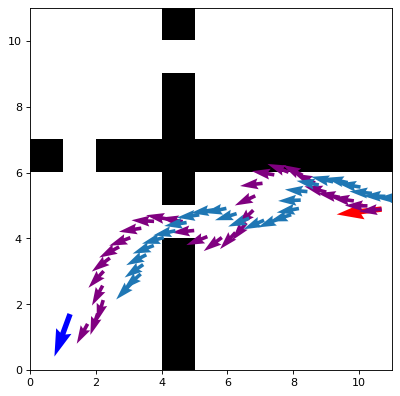

In [81]:
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
ax1.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
ax1.quiver(statearr[:,0] * gridSize, statearr[:,1] * gridSize, np.cos(statearr[:,2]), np.sin(statearr[:,2]), color='purple', scale=16.0, width=0.01)
ax1.quiver(trailerarr[:,0] * gridSize, trailerarr[:,1] * gridSize, np.cos(trailerarr[:,2]), np.sin(trailerarr[:,2]), color='C0', scale=16.0, width=0.01)
ax1.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.show()

In [7]:
data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1)))
np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/motion_planning/data/ctrlDataPfollowMazeAsd', data[1:], delimiter=',', fmt='%1.6f')

In [ ]:
# animate explored states
dist = np.linalg.norm(np.diff(exploredStates[:,:2], axis=0), axis=1)
plotIdx = np.where(np.abs(dist - 0.1) < 0.1)[0][::100]
print(plotIdx.shape)

def update_plot(i):
    scat = plt.scatter(x[plotIdx[i]:plotIdx[i+1]] * gridSize, y[plotIdx[i]:plotIdx[i+1]] * gridSize, color='C0', s=10, alpha=2/np.sqrt(plotIdx.shape[0]))
    
    return scat

numframes = plotIdx.shape[0] - 1
x, y = exploredStates[:,0], exploredStates[:,1]

fig = plt.figure(figsize=(8,8))
plt.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
plt.xlim([0, gridSize])
plt.ylim([0, gridSize])
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes))

print("saving animation")                            
ani.save('animation.mp4', fps=20)